#HW5: Autoencoders

In this homework, we will explore how to develop a simple Autoencoder. As a dataset, we will use the MNIST dataset. It contains handwritten digits images.
In the first part, we will learn how to develop a simple shallow autoencoder, then we will develop a deep version. Next, we will experiment with the application of autoencoder on denoising data task (denoising-autoencoder). Finally, we will apply this model to sequential domains, considering the IMDB dataset, already used in HW4.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

###Load Dataset
We load the MNIST dataset, using tf.keras.datasets. The dataset contains 60,000 training images and 10,000 testing images.
The value of each pixel is between 0 and 255, and it represents a point of an image of size 28 x 28. We will normalize all values between 0 and 1, and we will flatten the 28x28 images into vectors of size 784.
Finally, since no validation set is defined, we split the test set in a validation set and a new test set.

In [7]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid = x_train[:10000]
x_train = x_train[10000:]

11493376/11490434 [==============================] - 0s 0us/step


##[TO COMPLETE] Exercise 5.1: Singular Value Decomposition

Principal component analysis (PCA) and singular value decomposition (SVD) are both classical linear dimensionality reduction methods that attempt to find linear combinations of features in the original high dimensional data matrix to construct a meaningful representation of the dataset.
In this first part of the HW, we will focus our attention on SVD decomposition, a numerical stable method. Given a matrix X, the SVD decomposes it into the product of two unitary matrices V and U and a rectangular diagonal matrix of singular values S:

$$ X=V \cdot S \cdot U^T.$$

SVD is already implemented in NumPy as np.linalg.svd. In our case, the X matrix will represent the training set, where each row is a sample (therefore the number of columns will be the number of input features).

Note that, the X matrix in our case will have a huge number of rows (we have 50000 input samples) and only 784 columns. Therefore to optime the memory consumption, we can compute the SVD of the covariance matrix. An interesting property of the SVD is that we compute the decomposition of the covariance matrix $C= X^T \cdot X$, and we will obtain the following decomposition:

$$ C= U \cdot S^2 \cdot U^T$$

Since we need just the matrix U to compute the compressed version of our data, this method will be very convenient. If you are using the collab free plan, the quantity of available ram is not sufficient to compute the SVD of X, therefore computing the SVD of the covariance matrix turns out to be the best solution. 

In [ ]:
def svd_k(X, k):
  # Compute covariance matrix
  C = np.dot(X.T, X)
  # SVD decomposition
  U, s_sqr, U_T = np.linalg.svd(C, full_matrices=False)
  # Limit the number columns of U to k
  U_k=U[:,:k]
  return U_k


Let's define the ENCODING_DIM, that will be the size of the compressed version of input data. And compute the compressed version of the training set and the test set.

**[TO COMPLETE]**: What happens varying the ENCODING_DIM? test  and discuss the results in a new cell after the following one.

---

> **RESULTS**


---


The higher the encoding dimension is, the more similar the restructured images (output) and their inputs are (equivantly, the lower the error is). Since our goal is to compress data, there is no point in going over the dimension of the input. 

With a very low dimension, the output is very noisy/blurry and the error is quite high (digits are not even recognisible).

Meanwhile when the dimension reaches 748 (same as dimension of the input) the error is 0 and the output is equal to the input, therefore our model learns the identity function on the training set. (This is useless since no compression is happening). Since the model learns the identity, the mean error is 0 on the whole set.


In [ ]:
ENCODING_DIM = 748

U_k=svd_k(x_train, ENCODING_DIM)

x_training_pca = np.dot(x_train, U_k)
x_test_pca = np.dot(x_test, U_k)



Reconstruct the input and check how much information was lost due to the compression, by computing the mean squared error between the original input and the reconstruction, and by plotting the reconstructed images.

In [ ]:
x_training_reco= np.dot(x_training_pca, U_k.T)
x_test_reco= np.dot(x_test_pca, U_k.T)

In [ ]:
accuracy_train = ((x_train - x_training_reco)**2).mean()
accuracy_test = ((x_test - x_test_reco)**2).mean()

print("training mse: %.5f" % ( accuracy_train))
print("test mse: %.5f" % ( accuracy_test))

training mse: 0.00000
test mse: 0.00000


In [2]:
def plot_img(n, input_data, decoded_imgs):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(input_data[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

Let's check how well the input can be reconstructed by printing a few of the input images and the corresponding reconstructions. Obviously, all these evaluations have to be done on the test set.

The first row of shown images corresponds to input data, while the second one contains the reconstructions.

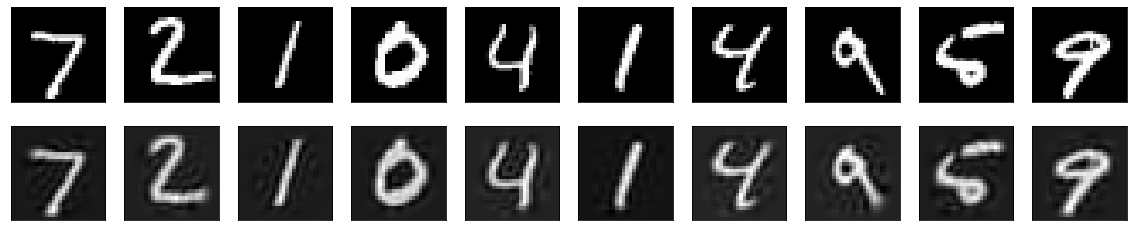

In [ ]:
# ENCODING_DIM = 120
plot_img(10, x_test, x_test_reco)

**TESTING**

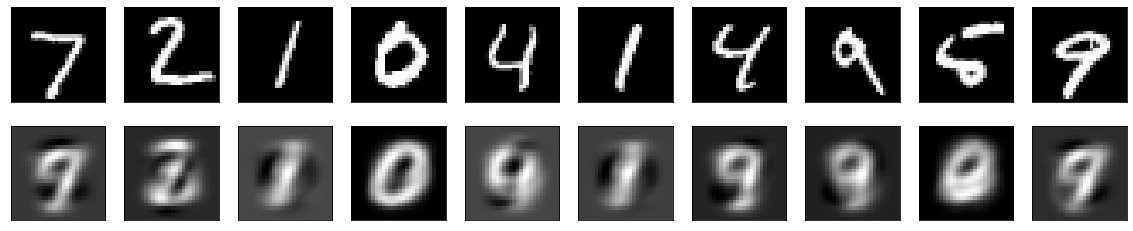

In [ ]:
# ENCODING_DIM = 5
plot_img(10, x_test, x_test_reco)

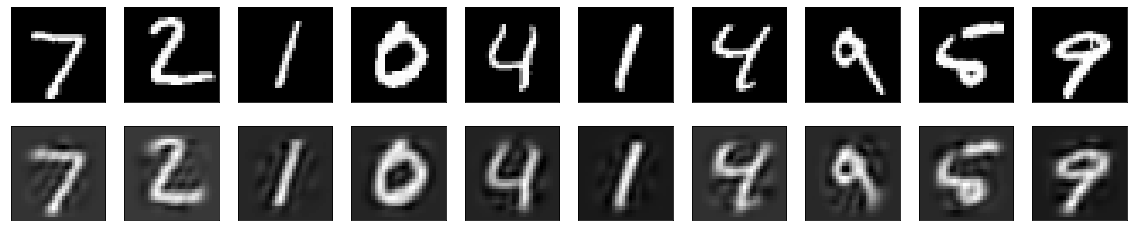

In [ ]:
# ENCODING_DIM = 60
plot_img(10, x_test, x_test_reco)

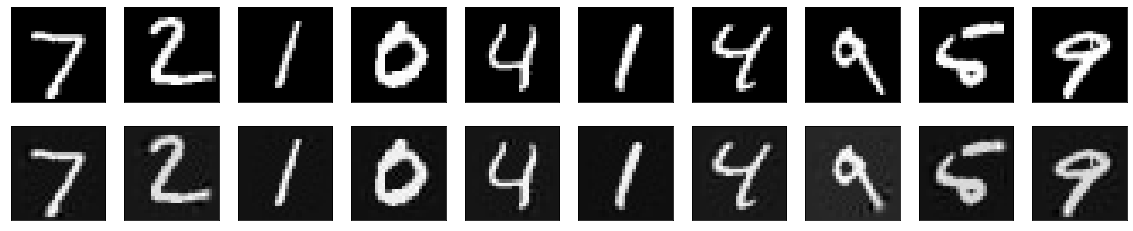

In [ ]:
# ENCODING_DIM = 320
plot_img(10, x_test, x_test_reco)

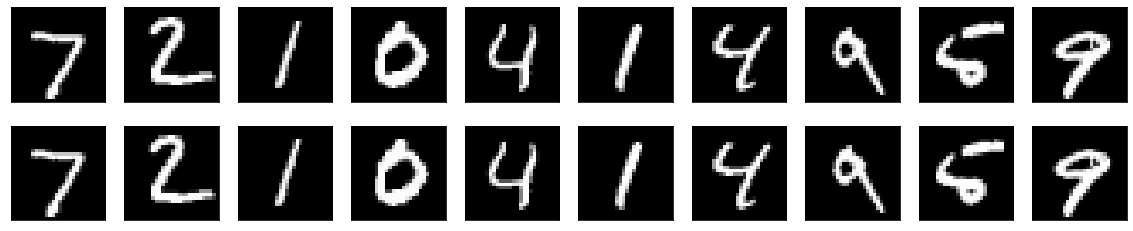

In [ ]:
# ENCODING_DIM = 748
plot_img(10, x_test, x_test_reco)

## [TO COMPLETE] Exercise 5.2: Shallow Linear Autoencoder
Let's define a model that consists of a single fully-connected neural layer. The hidden layer and the output layer act as the encoder and the decoder, respectively. Differently than the previous homework, instead of using Keras.Sequential(), we define the various part of the model (encoder and decoder) separately and then we create the final model. 

**[TO COMPLETE]** check the results and compare them versus the results obtained with the SVD. Add a cell  at the end of this section (after the result of the linear autoencoder) where you give an explanation of the relation between the results obtained  by the shallow linear autoencoder and the ones obtained by the SVD decomposition.


In [ ]:
ENCODING_DIM = 120

input_img = tf.keras.layers.Input(shape=(784,))
#Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(input_img)

#...and the decoder...
decoded = tf.keras.layers.Dense(784, activation='linear')(encoded)

#and finally the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

#Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')


Print the model summary.

In [ ]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 120)               94200     
_________________________________________________________________
dense_1 (Dense)              (None, 784)               94864     
Total params: 189,064
Trainable params: 189,064
Non-trainable params: 0
_________________________________________________________________


Train the model.

In [ ]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
98/98 [==============================] - 3s 24ms/step - loss: 0.0824 - val_loss: 0.0142
Epoch 2/15
98/98 [==============================] - 2s 19ms/step - loss: 0.0129 - val_loss: 0.0091
Epoch 3/15
98/98 [==============================] - 2s 20ms/step - loss: 0.0084 - val_loss: 0.0069
Epoch 4/15
98/98 [==============================] - 2s 20ms/step - loss: 0.0067 - val_loss: 0.0061
Epoch 5/15
98/98 [==============================] - 2s 20ms/step - loss: 0.0060 - val_loss: 0.0057
Epoch 6/15
98/98 [==============================] - 2s 19ms/step - loss: 0.0056 - val_loss: 0.0053
Epoch 7/15
98/98 [==============================] - 2s 20ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 8/15
98/98 [==============================] - 2s 18ms/step - loss: 0.0052 - val_loss: 0.0052
Epoch 9/15
98/98 [==============================] - 2s 19ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 10/15
98/98 [==============================] - 2s 18ms/step - loss: 0.0050 - val_loss: 0.0053
Epoch 11/

Plot the loss and the accuracy curves on the validation set, and the accuracy on the test set.


In [3]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

313/313 - 0s - loss: 0.0054
test mse: 0.00538


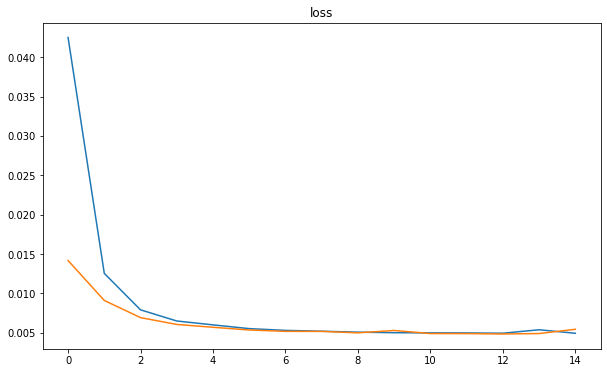

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

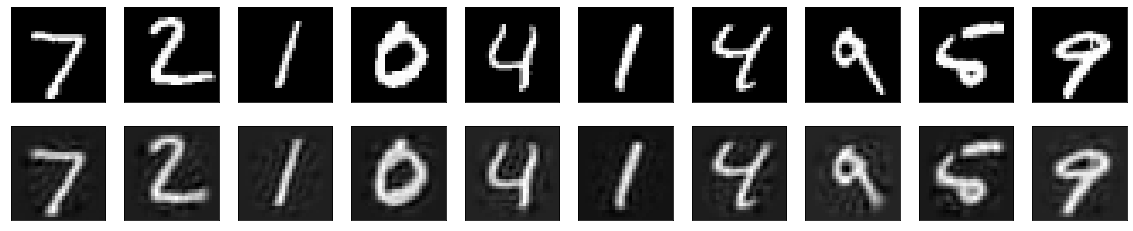

In [ ]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, x_test, decoded_imgs)


---

> **DISCUSSION**

---
* SVD performance

> training mse: 0.00464. test mse: 0.00455

* AE performance

> training mse: 0.0051. test mse: 0.00514

The result are going to be very similar, since we are doing practically the same operation. The encoder maps an input with a point on a low dimensional state and then the decoder projects it to a point in the original input space. Since we are not applying any non-linear function on the autoencoder, we are doing essentialy the same as in the SVD. Thus the performance of both models are similar, their mse vary on less than 0.001.

What we are doing is looking for two matrices (linear operators, formed by the weights in the case of the AE, matrices of descomposition in the case of SVD) which when we apply the first one to the input matrix gives us the encoded data. Then, we apply the other matrix to the encoded data to decode it and get the reconstructed input. An activation function would be applied after applying a matrix to the input of each layer, but since here we are not using any, the method is essentially the same in SVD and Shallow AE. **The formulation of the problem is equivalent, but the numerical approach to find the solution changes.**

This is true in this case because we are dealing with a linear autoencoder. SVD seems to be cheaper computationally at solving this task. AE can be arranged (with depth and activation functions) to learn more complex tasks or non linear ones, but SVD is more limited.

---

**CORRECTION**: Both are theoretically equivalent, but the training is done differently. SVD uses a one step method while the Linear AE uses gradient descent.


##[TO COMPLETE] Exercise 5.3: Shallow non-linear autoencoders

**[TO COMPLETE]** replicate the code of Exercise 5.2 but in this case, instead of using linear activation functions use  non-linear ones. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained in Exercise 5.2. (Insert your code and  theoretical discussion into  cells immediately below this one.)


---

> **DISCUSSION**

---

We are doing a regression, since the output of each neuron in the output or decoder layer is not divided in cathegorical classes, but must be a number between 0 and 1 (the value of that specific pixel).

I chose bounded activation functions, such as sigmoid or tanh, for the output layer (since the output of each neuron must be a number between 0 and 1 (we scaled it from 0 - 255 to 0 - 1 at the beggining). This functions are well suited for regression problem in this case specifically because the regression is done only in the image of these functions, which is [0,1]. 

For the encoded layer, theoretically an unbounded activation could be use, too. I could not improve the performance with any non linear function. Keras documentation advises to use a Relu activation of the encoded layer and a sigmoid on the decoded. In my experience, the performance was better using a linear on the first one and a sigmoid on the second. With this model the performance improve with respect to the linear model.

The best model I found without any linear activation is sigmoid with sigmoid (in case the exercise asks to use non linear act on both layers). The results of the testing are below.


---
> **TESTING**
---

sigmoid and sigmoid --- test mse: 0.00433

linear and sigmoid --- test mse: 0.00162

linear and relu --- test mse: 0.00286

relu and sigmoid --- test mse: 0.01529

linear and linear (previous model) --- test mse: 0.00514


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               94200     
_________________________________________________________________
dense_3 (Dense)              (None, 784)               94864     
Total params: 189,064
Trainable params: 189,064
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
98/98 [==============================] - 3s 23ms/step - loss: 0.0736 - val_loss: 0.0344
Epoch 2/15
98/98 [==============================] - 2s 21ms/step - loss: 0.0311 - val_loss: 0.0224
Epoch 3/15
98/98 [==============================] - 2s 18ms/step - loss: 0.0210 - val_loss: 0.0167
Epoch 4/15
98/98 [==============================] - 2s 18ms/step - loss: 0.0158 - val_

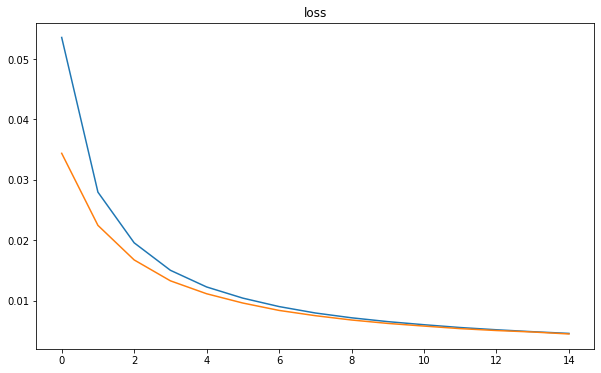

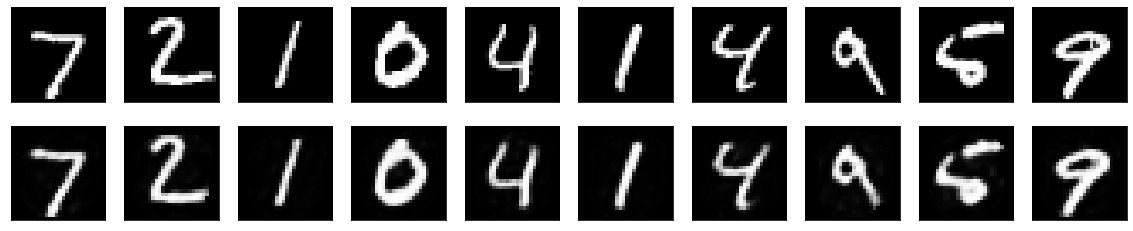

In [ ]:
ENCODING_DIM = 120

input_img = tf.keras.layers.Input(shape=(784,))
#Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='sigmoid')(input_img)

#...and the decoder...
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(encoded)

#and finally the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

#Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')

autoencoder.summary()

history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, x_test, decoded_imgs)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 120)               94200     
_________________________________________________________________
dense_5 (Dense)              (None, 784)               94864     
Total params: 189,064
Trainable params: 189,064
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
98/98 [==============================] - 2s 20ms/step - loss: 0.0710 - val_loss: 0.0296
Epoch 2/15
98/98 [==============================] - 2s 20ms/step - loss: 0.0273 - val_loss: 0.0216
Epoch 3/15
98/98 [==============================] - 2s 20ms/step - loss: 0.0193 - val_loss: 0.0093
Epoch 4/15
98/98 [==============================] - 2s 20ms/step - loss: 0.0073 - val_

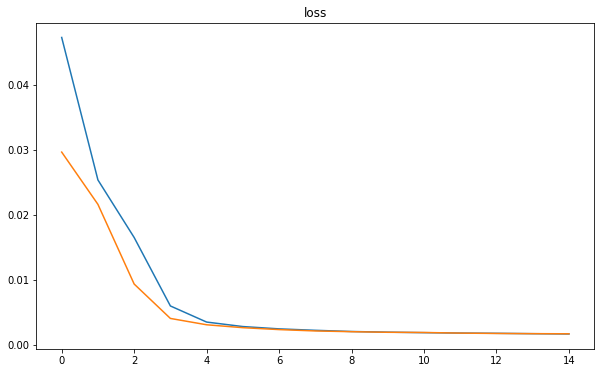

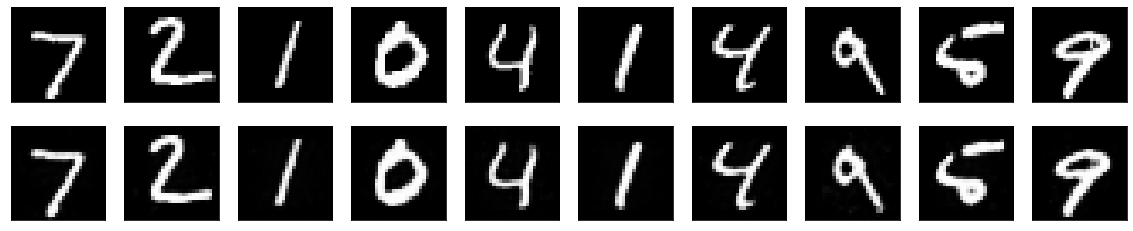

In [ ]:
ENCODING_DIM = 120

input_img = tf.keras.layers.Input(shape=(784,))
#Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(input_img)

#...and the decoder...
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(encoded)

#and finally the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

#Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')

autoencoder.summary()

history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, x_test, decoded_imgs)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               94200     
_________________________________________________________________
dense_3 (Dense)              (None, 784)               94864     
Total params: 189,064
Trainable params: 189,064
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
98/98 [==============================] - 2s 19ms/step - loss: 0.0516 - val_loss: 0.0079
Epoch 2/15
98/98 [==============================] - 2s 19ms/step - loss: 0.0069 - val_loss: 0.0051
Epoch 3/15
98/98 [==============================] - 2s 18ms/step - loss: 0.0049 - val_loss: 0.0042
Epoch 4/15
98/98 [==============================] - 2s 19ms/step - loss: 0.0041 - val_

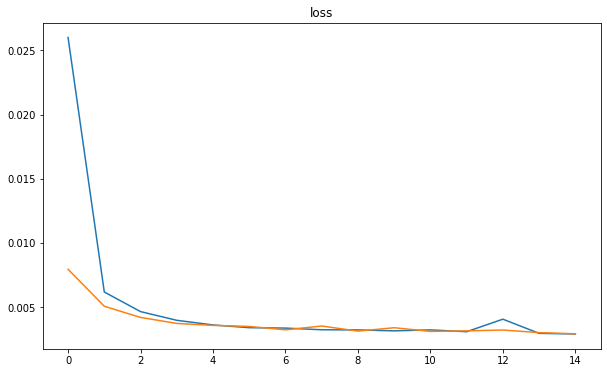

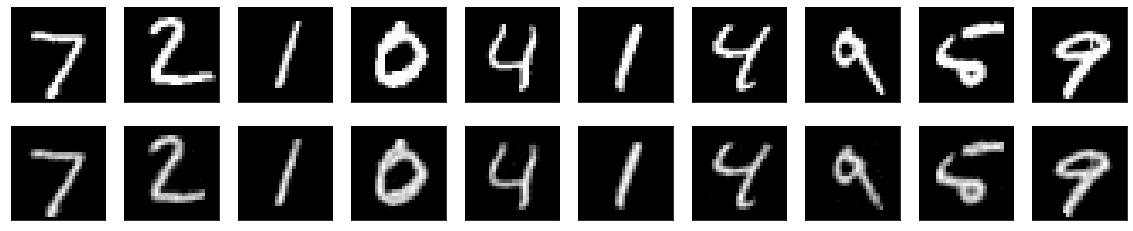

In [ ]:
ENCODING_DIM = 120

input_img = tf.keras.layers.Input(shape=(784,))
#Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(input_img)

#...and the decoder...
decoded = tf.keras.layers.Dense(784, activation='relu')(encoded)

#and finally the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

#Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')

autoencoder.summary()

history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, x_test, decoded_imgs)

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_6 (Dense)              (None, 120)               94200     
_________________________________________________________________
dense_7 (Dense)              (None, 784)               94864     
Total params: 189,064
Trainable params: 189,064
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
98/98 [==============================] - 2s 20ms/step - loss: 0.0708 - val_loss: 0.0291
Epoch 2/15
98/98 [==============================] - 2s 19ms/step - loss: 0.0265 - val_loss: 0.0207
Epoch 3/15
98/98 [==============================] - 2s 18ms/step - loss: 0.0200 - val_loss: 0.0184
Epoch 4/15
98/98 [==============================] - 2s 18ms/step - loss: 0.0182 - val_

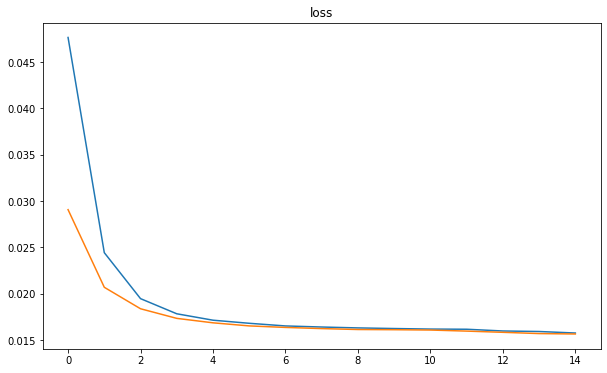

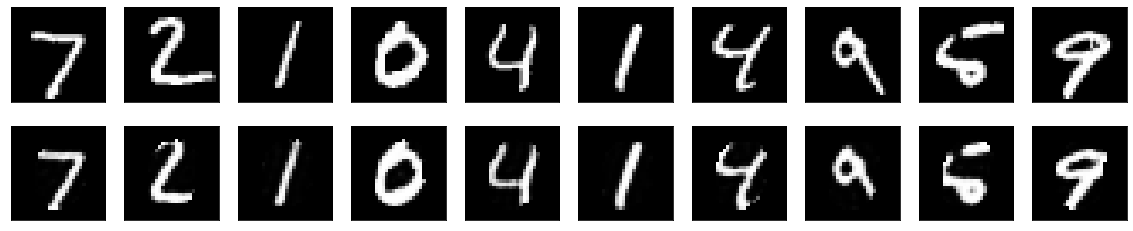

In [ ]:
ENCODING_DIM = 120

input_img = tf.keras.layers.Input(shape=(784,))
#Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='relu')(input_img)

#...and the decoder...
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(encoded)

#and finally the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

#Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')

autoencoder.summary()

history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, x_test, decoded_imgs)

##[TO COMPLETE] Exercise 5.4: Deep Autoencoder
**[TO COMPLETE]**: Define a deep version of the Autoeancoder defined above. The autoencoder has to use at least 5 layers. The model will use $n$ layers for encoding, and n-1 for decoding. The layers sizes of the encoding part decrease at each layer (i.e. 784->128->64, where 64 is the encoding dim). The decoding part layers dimensions progression turns out to be mirrored (i.e 128->784, the resulting overall structure recalls an hourglass).
Similarly than what we did above, print the model summary, the loss curves during the training, the achieved loss on the test set, and some input images with the corresponding decoding.


---
**CORRECTED STRUCTURE OF THE MODEL**

In [4]:
ENCODING_DIM = 64
input_img = tf.keras.layers.Input(shape=(784,))
#[TO COMPLETE]

#CORRECTION: Added 1 layer to the encoder

encoded1 = tf.keras.layers.Dense(784, activation='relu')(input_img)
encoded2 = tf.keras.layers.Dense(128, activation='linear')(encoded1)
encoded3 = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(encoded2)
#...and the decoder...
decoded1 = tf.keras.layers.Dense(128, activation='linear')(encoded3)
decoded2 = tf.keras.layers.Dense(784, activation='sigmoid')(decoded1)

#and finally the autoencoder
#[TO COMPLETE]

autoencoder = tf.keras.models.Model(input_img, decoded2)

autoencoder.compile(optimizer='adam', loss='mse')

In [5]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 784)               615440    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_4 (Dense)              (None, 784)               101136    
Total params: 833,632
Trainable params: 833,632
Non-trainable params: 0
_______________________________________________________

In [8]:
history = autoencoder.fit(x_train, x_train, epochs= 50, batch_size= 512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/50
98/98 [==============================] - 4s 40ms/step - loss: 0.0605 - val_loss: 0.0286
Epoch 2/50
98/98 [==============================] - 4s 39ms/step - loss: 0.0221 - val_loss: 0.0171
Epoch 3/50
98/98 [==============================] - 4s 38ms/step - loss: 0.0149 - val_loss: 0.0126
Epoch 4/50
98/98 [==============================] - 4s 39ms/step - loss: 0.0116 - val_loss: 0.0103
Epoch 5/50
98/98 [==============================] - 4s 39ms/step - loss: 0.0098 - val_loss: 0.0090
Epoch 6/50
98/98 [==============================] - 4s 39ms/step - loss: 0.0086 - val_loss: 0.0081
Epoch 7/50
98/98 [==============================] - 4s 39ms/step - loss: 0.0078 - val_loss: 0.0074
Epoch 8/50
98/98 [==============================] - 4s 39ms/step - loss: 0.0072 - val_loss: 0.0069
Epoch 9/50
98/98 [==============================] - 4s 39ms/step - loss: 0.0067 - val_loss: 0.0064
Epoch 10/50
98/98 [==============================] - 4s 39ms/step - loss: 0.0063 - val_loss: 0.0061
Epoch 11/

313/313 - 1s - loss: 0.0027
test mse: 0.00269


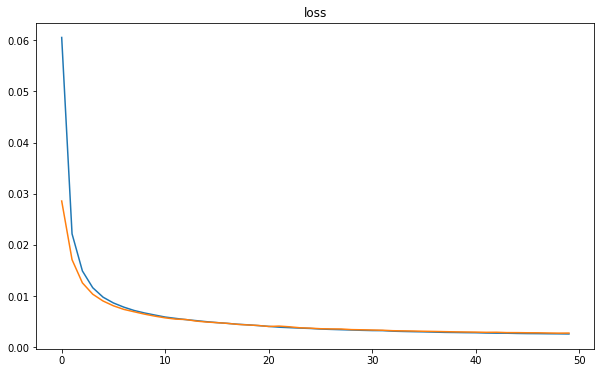

In [9]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

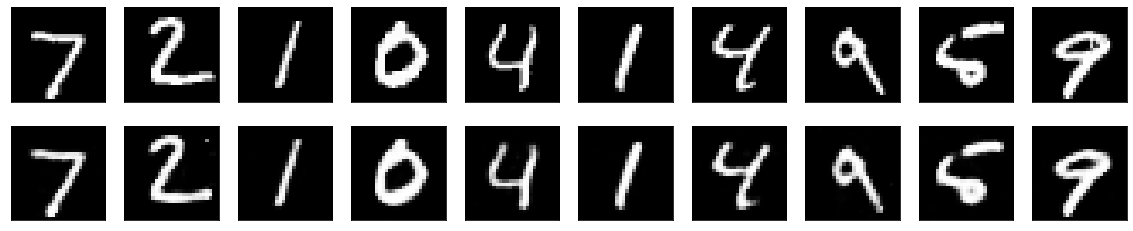

In [10]:
decoded_imgs = autoencoder.predict(x_test)

plot_img(10, x_test, decoded_imgs)


## [TO COMPLETE] Exercise 5.5: Denoising Autoencoder

Let's now use a shallow autoencoder to denoise the input data.
Firstly, define a noisy input by adding some noise to our input data. We define a noise factor that can be used to modify the amount of noise to add to the input data. Check how much it influences the denoising capability of the autoencoder.
**NOTE: in the code at the bottom noise_factor is added and not multiplied for numerical reasons. You may want to try the version with multiplication to verify it is more unstable.**

---
> **OBSERVATION**


 

1.   When the noise factor is added, the result is much noisier (digits can not even be recognised) than when it is multiplied. 
2.   As this is a denoising task, I will test also overcomplete autoencoders to extract the miningful features.

---


In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid, y_valid = x_train[:10000],y_train[:10000]
x_train, y_train = x_train[10000:],y_train[10000:]

noise_factor = 0.3

x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_valid_noisy = x_valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_valid.shape)


x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)

Plot some noisy inputs.

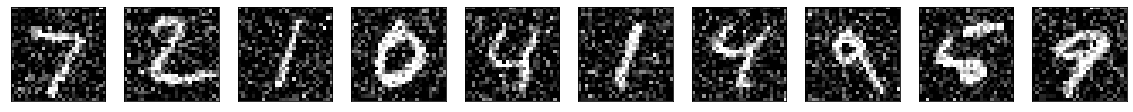

In [ ]:
# here's what the noisy digits look like
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**[TO COMPLETE]** Define a shallow autoencoder able to compute a de-noised version of the input (obtained by unsing a noise_factor >= 0.3). 

In [ ]:
input_img = tf.keras.layers.Input(shape=(784,))
#[TO COMPLETE]

ENCODING_DIM = 820

#Define the encoder...
encoded = tf.keras.layers.Dense(784, activation='linear')(input_img)
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(encoded)

#...and the decoder...
decoded = tf.keras.layers.Dense(784, activation='linear')(encoded)

#and finally the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

#[TO COMPLETE]
#Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')

In [ ]:
autoencoder.summary()

Model: "model_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_49 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_131 (Dense)            (None, 784)               615440    
_________________________________________________________________
dense_132 (Dense)            (None, 820)               643700    
_________________________________________________________________
dense_133 (Dense)            (None, 784)               643664    
Total params: 1,902,804
Trainable params: 1,902,804
Non-trainable params: 0
_________________________________________________________________


**[TO COMPLETE]** Train the model by passing the noisy input and the clean target.

In [ ]:
#[TO COMPLETE]
history = autoencoder.fit(x_train_noisy, x_train, epochs= 50, batch_size= 512, shuffle=True, validation_data=(x_valid_noisy, x_valid))

Epoch 1/50
98/98 [==============================] - 8s 81ms/step - loss: 53.6809 - val_loss: 0.1543
Epoch 2/50
98/98 [==============================] - 8s 79ms/step - loss: 0.1204 - val_loss: 0.1022
Epoch 3/50
98/98 [==============================] - 8s 79ms/step - loss: 0.0941 - val_loss: 0.0873
Epoch 4/50
98/98 [==============================] - 8s 79ms/step - loss: 0.5692 - val_loss: 0.0865
Epoch 5/50
98/98 [==============================] - 8s 80ms/step - loss: 0.0792 - val_loss: 0.0737
Epoch 6/50
98/98 [==============================] - 8s 79ms/step - loss: 0.0705 - val_loss: 0.0672
Epoch 7/50
98/98 [==============================] - 8s 79ms/step - loss: 0.0648 - val_loss: 0.0622
Epoch 8/50
98/98 [==============================] - 8s 79ms/step - loss: 0.0602 - val_loss: 0.0580
Epoch 9/50
98/98 [==============================] - 8s 80ms/step - loss: 0.0563 - val_loss: 0.0543
Epoch 10/50
98/98 [==============================] - 8s 79ms/step - loss: 0.0528 - val_loss: 0.0511
Epoch 11

---
**TESTED MODELS**

---

- Only one layer on encoder (820-784) (Achieved the best performance, even though it has an unusual structure).

313/313 - 1s - loss: 0.0106
test mse: 0.01058

---

- 2 layers on encoder. ENCODING_DIM = 512

loss: 0.0139 - val_loss: 0.0139

---

- 2 layers on encoder. ENCODING_DIM = 248

loss: 0.0110 - val_loss: 0.0111

---

- 2 layers on encoder. ENCODING_DIM = 128

6s 64ms/step - loss: 0.0120 - val_loss: 0.0120

---

- 2 layers on encoder. ENCODING_DIM = 64

6s 58ms/step - loss: 0.0142 - val_loss: 0.0142

---

- Overcomplete (784-820-784)

loss: 0.0130 - val_loss: 0.0130

---


313/313 - 1s - loss: 0.0119
test mse: 0.01192


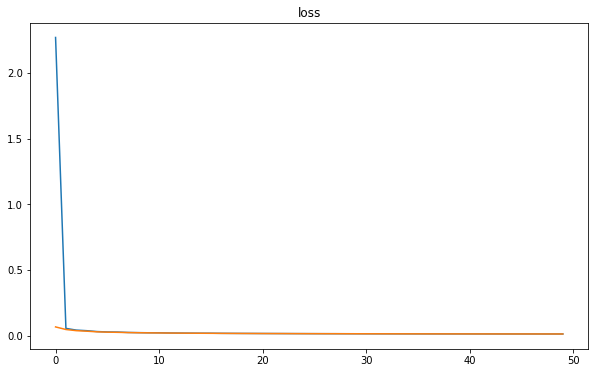

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test_noisy, x_test, verbose=2)
print("test mse: %.5f" % (scores))

**[TO COMPLETE]** Check the result by plotting some input images and the corresponding denoised outputs.

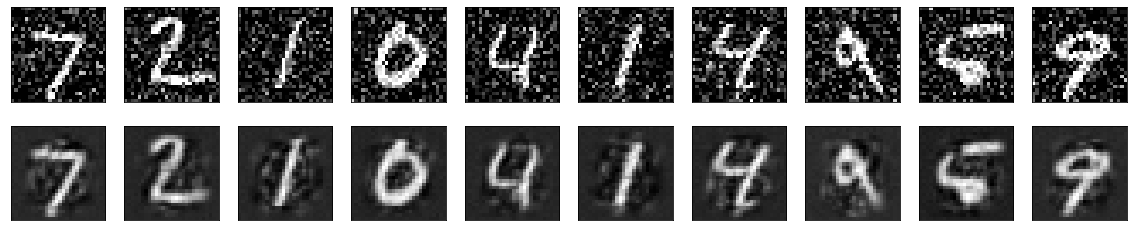

In [ ]:
decoded_imgs = autoencoder.predict(x_test_noisy)

plot_img(10, x_test_noisy, decoded_imgs)

# Only one encoder layer with latent_dim = 820

---
> Now I will try **adding** the noise factor, which produces a noisier output. I will also try undercomplete encoders to approach this task.
---

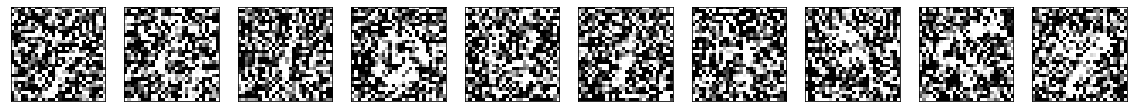

Epoch 1/70
98/98 [==============================] - 7s 66ms/step - loss: 52.5403 - val_loss: 0.2364
Epoch 2/70
98/98 [==============================] - 6s 66ms/step - loss: 0.2061 - val_loss: 0.1894
Epoch 3/70
98/98 [==============================] - 6s 64ms/step - loss: 0.1798 - val_loss: 0.1720
Epoch 4/70
98/98 [==============================] - 6s 63ms/step - loss: 0.1651 - val_loss: 0.1594
Epoch 5/70
98/98 [==============================] - 6s 65ms/step - loss: 0.1535 - val_loss: 0.1487
Epoch 6/70
98/98 [==============================] - 6s 63ms/step - loss: 0.1434 - val_loss: 0.1391
Epoch 7/70
98/98 [==============================] - 6s 65ms/step - loss: 0.1342 - val_loss: 0.1303
Epoch 8/70
98/98 [==============================] - 6s 63ms/step - loss: 0.1463 - val_loss: 0.1231
Epoch 9/70
98/98 [==============================] - 6s 63ms/step - loss: 0.1182 - val_loss: 0.1176
Epoch 10/70
98/98 [==============================] - 6s 64ms/step - loss: 0.1319 - val_loss: 0.1082
Epoch 11

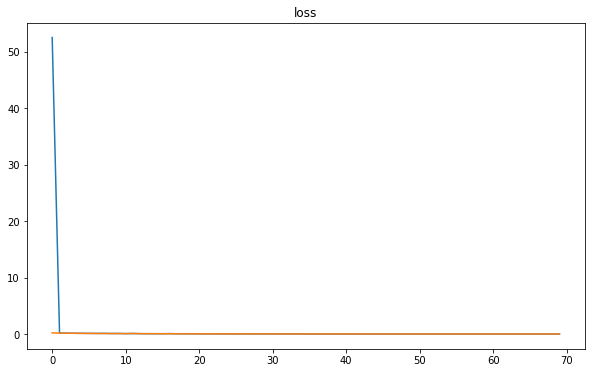

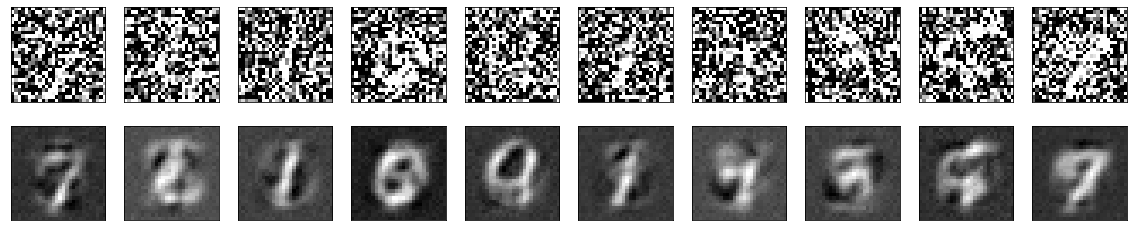

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid, y_valid = x_train[:10000],y_train[:10000]
x_train, y_train = x_train[10000:],y_train[10000:]

noise_factor = 0.3

x_train_noisy = x_train + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_valid_noisy = x_valid + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_valid.shape)


x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)

# here's what the noisy digits look like
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#####################
# Autoencoder model # 
#####################

input_img = tf.keras.layers.Input(shape=(784,))
#[TO COMPLETE]

ENCODING_DIM = 256

#Define the encoder...
encoded = tf.keras.layers.Dense(748, activation='linear')(input_img)
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(encoded)

#...and the decoder...
decoded = tf.keras.layers.Dense(784, activation='linear')(encoded)

#and finally the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

#[TO COMPLETE]

#Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')

# Training
history = autoencoder.fit(x_train_noisy, x_train, epochs= 70, batch_size= 512, shuffle=True, validation_data=(x_valid_noisy, x_valid))

plot_loss(history)

scores = autoencoder.evaluate(x_test_noisy, x_test, verbose=2)
print("test mse: %.5f" % (scores))

decoded_imgs = autoencoder.predict(x_test_noisy)

plot_img(10, x_test_noisy, decoded_imgs)


---
I also tried this model with less parameters and similar (even better) performance.

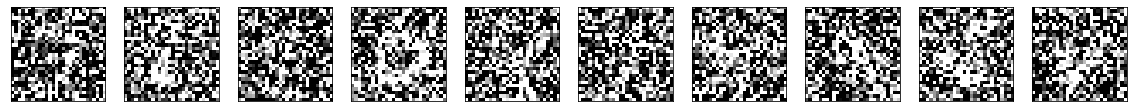

Epoch 1/50
98/98 [==============================] - 4s 37ms/step - loss: 4.0100 - val_loss: 0.1655
Epoch 2/50
98/98 [==============================] - 3s 35ms/step - loss: 0.1491 - val_loss: 0.1349
Epoch 3/50
98/98 [==============================] - 3s 35ms/step - loss: 0.1230 - val_loss: 0.1128
Epoch 4/50
98/98 [==============================] - 4s 37ms/step - loss: 0.1039 - val_loss: 0.0962
Epoch 5/50
98/98 [==============================] - 4s 37ms/step - loss: 0.0893 - val_loss: 0.0834
Epoch 6/50
98/98 [==============================] - 4s 37ms/step - loss: 0.0781 - val_loss: 0.0736
Epoch 7/50
98/98 [==============================] - 4s 39ms/step - loss: 0.0697 - val_loss: 0.0664
Epoch 8/50
98/98 [==============================] - 4s 36ms/step - loss: 0.0635 - val_loss: 0.0611
Epoch 9/50
98/98 [==============================] - 3s 35ms/step - loss: 0.0589 - val_loss: 0.0571
Epoch 10/50
98/98 [==============================] - 3s 33ms/step - loss: 0.0553 - val_loss: 0.0539
Epoch 11/

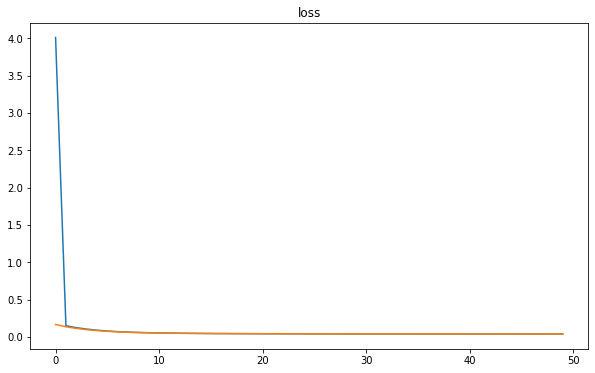

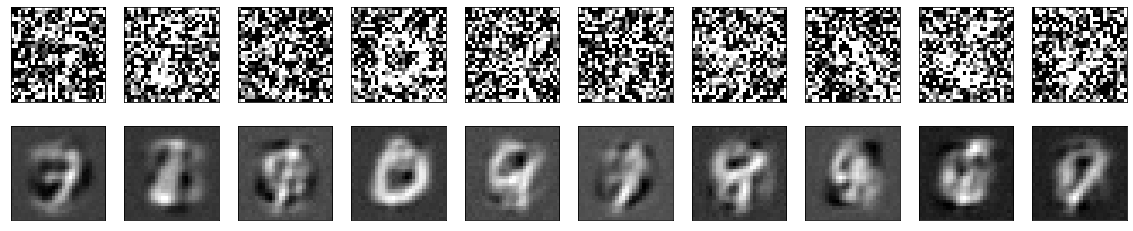

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid, y_valid = x_train[:10000],y_train[:10000]
x_train, y_train = x_train[10000:],y_train[10000:]

noise_factor = 0.3

x_train_noisy = x_train + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_valid_noisy = x_valid + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_valid.shape)


x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)

# here's what the noisy digits look like
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#####################
# Autoencoder model # 
#####################

input_img = tf.keras.layers.Input(shape=(784,))
#[TO COMPLETE]

ENCODING_DIM = 256

#Define the encoder...
encoded = tf.keras.layers.Dense(256, activation='linear')(input_img)
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(encoded)

#...and the decoder...
decoded = tf.keras.layers.Dense(784, activation='linear')(encoded)

#and finally the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

#[TO COMPLETE]

#Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')

# Training
history = autoencoder.fit(x_train_noisy, x_train, epochs= 50, batch_size= 512, shuffle=True, validation_data=(x_valid_noisy, x_valid))

plot_loss(history)

scores = autoencoder.evaluate(x_test_noisy, x_test, verbose=2)
print("test mse: %.5f" % (scores))

decoded_imgs = autoencoder.predict(x_test_noisy)

plot_img(10, x_test_noisy, decoded_imgs)


## Exercise 5.6: Linear Autoencoder for sequences

Let's define a linear autoencoder for sequences. In this case, as dataset, we will use the IMDB dataset (already presented in HW4). To have a model that can be trained and tested in a reasonable time (and that works also with the memory limitation that we have in Colab), we will limit the number of training samples and test samples.

In [ ]:
num_words = 100
(X_train, _), (X_test, _) = keras.datasets.imdb.load_data(num_words=num_words)

X_train=X_train[:10000]

(X_valid, X_test) = X_test[:1250], X_test[-1250:]

word_index = keras.datasets.imdb.get_word_index()

reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])


maxlen = 90
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)



17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])


1646592/1641221 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In this case, we want to use as input/target a one-hot representation for each word. To convert the index representation provided by IMDB dataset loader we use the to_categorical method to transform them in the corresponding one hot representation.

In [ ]:
from keras.utils import to_categorical


X_train_one_hot=to_categorical(X_train_trim)
X_test_one_hot=to_categorical(X_test_trim)
X_valid_one_hot=to_categorical(X_valid_trim)


Define a linear shallow autoencoder for sequences. The structure will be similar to the model defined in Exercise 5.2, while the used encoding layer is defined by using tf.keras.layers.SimpleRNN. Note that it uses linear activations. The decoding layer exploits [tf.keras.layers.TimeDistributed](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed) that allows using the same dense cell at each time step of the sequence. 

In [ ]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.SimpleRNN(50, return_sequences=True, activation='linear')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='linear'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 90, 100)]         0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 90, 50)            7550      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 90, 100)           5100      
Total params: 12,650
Trainable params: 12,650
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 8s 85ms/step - loss: 0.5082 - categorical_accuracy: 0.0251 - val_loss: 0.1201 - val_categorical_accuracy: 0.1350
Epoch 2/50
79/79 [==============================] - 6s 81ms/step - loss: 0.1063 - categorical_accuracy: 0.2146 - val_loss: 0.0822 - val_categorical_accuracy: 0.3843
Epoch 3/50
79/79 [==============================] - 6s 81ms/step - loss: 0.0766 - categorical_accuracy: 0.4234 - val_loss: 0.0682 - val_categorical_accuracy: 0.4670
Epoch 4/50
79/79 [==============================] - 6s 81ms/step - loss: 0.0649 - categorical_accuracy: 0.4845 - val_loss: 0.0613 - val_categorical_accuracy: 0.5039
Epoch 5/50
79/79 [==============================] - 6s 81ms/step - loss: 0.0591 - categorical_accuracy: 0.5216 - val_loss: 0.0574 - val_categorical_accuracy: 0.5470
Epoch 6/50
79/79 [==============================] - 6s 82ms/step - loss: 0.0551 - categorical_accuracy: 0.5650 - val_loss: 0.0526 - val_categorical_accuracy: 0.5673
Epoch 7/50

Let's plot the accuracy and the loss trends and check the reconstruction capability of the model by plotting the reconstruction of a test sample

40/40 - 0s - loss: 0.0146 - categorical_accuracy: 0.9209
categorical_accuracy: 92.09%


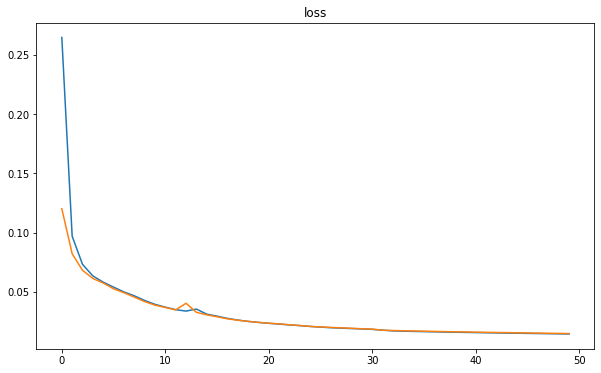

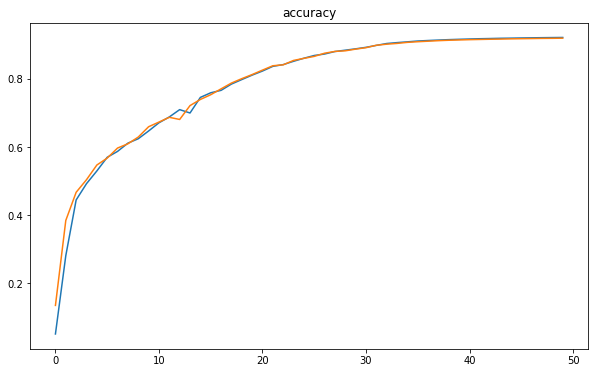

In [ ]:
def plot_categorical_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['categorical_accuracy'])
  plt.plot(history.epoch,history.history['val_categorical_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [ ]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just this <oov> <oov> <oov> <oov> as some only <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> only <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really so film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>


##[TO COMPLETE] Exercise 5.7: Non-Linear Autoencoder for sequences
**[TO COMPLETE]**: Replicate the code of the above exercise, but instead of using a simpleRNN with linear activation do the same  using  non-linear activation functions and using an LSTM layer. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained by the linear autoencoder for sequences.

Hint: using a non-linear function also in the dense layer after the RNN/LSTM one will help to obtain better results. The choice of this function should be based on the type of output data.

In [ ]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.LSTM(50, return_sequences=True, activation='tanh')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='softmax'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 90, 100)]         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 90, 50)            30200     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 90, 100)           5100      
Total params: 35,300
Trainable params: 35,300
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=20, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/20
79/79 [==============================] - 14s 149ms/step - loss: 0.0500 - categorical_accuracy: 0.3175 - val_loss: 0.0372 - val_categorical_accuracy: 0.4636
Epoch 2/20
79/79 [==============================] - 11s 145ms/step - loss: 0.0364 - categorical_accuracy: 0.4728 - val_loss: 0.0353 - val_categorical_accuracy: 0.4647
Epoch 3/20
79/79 [==============================] - 16s 201ms/step - loss: 0.0342 - categorical_accuracy: 0.4742 - val_loss: 0.0321 - val_categorical_accuracy: 0.4667
Epoch 4/20
79/79 [==============================] - 13s 166ms/step - loss: 0.0306 - categorical_accuracy: 0.4893 - val_loss: 0.0277 - val_categorical_accuracy: 0.4930
Epoch 5/20
79/79 [==============================] - 11s 145ms/step - loss: 0.0262 - categorical_accuracy: 0.5127 - val_loss: 0.0230 - val_categorical_accuracy: 0.5937
Epoch 6/20
79/79 [==============================] - 12s 146ms/step - loss: 0.0214 - categorical_accuracy: 0.6445 - val_loss: 0.0183 - val_categorical_accuracy: 0.746

40/40 - 1s - loss: 4.1628e-04 - categorical_accuracy: 1.0000
categorical_accuracy: 100.00%


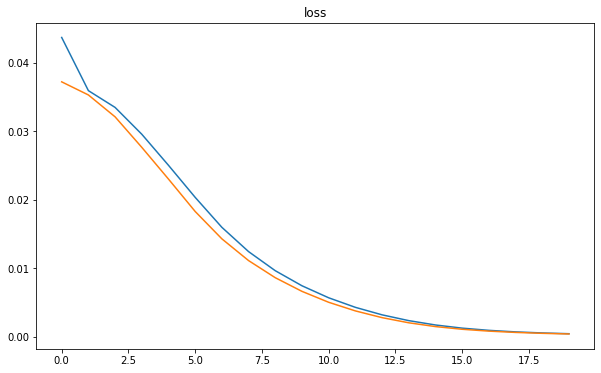

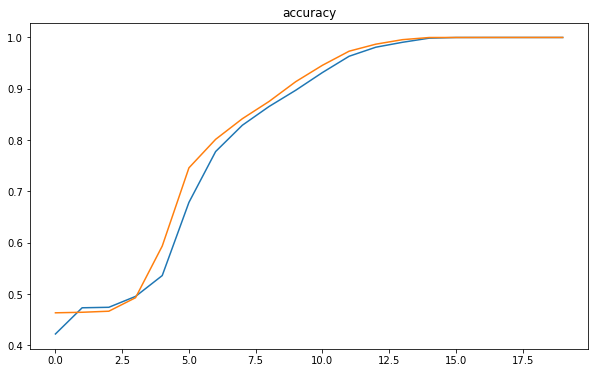

In [ ]:
plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

--- 
> **DISCUSSION**
---

At first, I chose a tanh activation function for the encoding layer (I could and tried different ones) and a sigmoid for the decoding one. This has to do to the kind of output expected. Each output neuron has a cathegorical binary output. We are using binary crossentropy as the loss function. So sigmoid and softmax are both suitable for this network's output. 

In the case of the sigmoid, the output is the probability of that neuron belonging to one of the output classes when there are two of them. 

Softmax is its generalisation to K>=2 classes. Sofmax enforces that the probabilities of your output classes sum up to 1, i.e, the sum of all output neurons is 1. 

In this case, working with a softmax on the output layer gives a better performance than with a sigmoid. Actually, 100% accuracy in only 20 epochs.

---
> **RESULTS**
---
- tanh-sigmoid  **-->**  categorical_accuracy: 0.9718 (50 epochs)

- tanh-softmax **-->** categorical_accuracy: 100.00%

---
> **COMPARATIVE WITH LINEAR MODEL**
---
The linear model achieved a categorical_accuracy of 92.09% after 50 epochs, while the nonlinear model with tanh and sigmoid achieved a perfect 100% accuracy within only 20 epochs. In conclusion, the nonlinearity gives our model much more expressionality and ability to learn both better and faster.